# 06. PyTorch Transfer Learning

What is Transfer Learning?

Transfer Learning is taking the parameters what one model has learned in another dataset and applying to our own
if problem:

    * Pretrained model = foundataion models

In [1]:
import torch
import torchvision

print(torch.__version__) # want 1.12+
print(torchvision.__version__)# want 1.13+

1.13.0
0.14.0


Now we've got the versions of torch and torchvision, we're after, let's import the code we've written in previous sections so that we don't have to write it all again.

In [2]:
# continue regular imports

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary
from going_modular import data_setup, engine

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
!nvidia-smi

Tue Nov 29 16:33:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.98       Driver Version: 526.98       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   63C    P0    28W /  N/A |      0MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Get data

We need our pizza, steak, sushi data to build a transfer learning model on.

In [5]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory exists.


In [6]:
# Set the train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

Now we've got some data, want to turn it into Pytorch DataLoaders.

To do so, we can use `data_setup.py` and `create_dataloaders()` function to turn our data into PyTorch DataLoaders.

There's one thing we have to think about when loading: how to  **transform** it ?

And with `torchvision` 0.13+ there's two ways to do this:
1. Manually created transforms - you define what transforms you want your data to go through.
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to do.

**Important point:** When using a pretrained model, it's important that the data(including your custom data) that you pass through it it **transformed** in the same way that the data the model was trained on.

In [7]:
from going_modular import data_setup

### 2.1 Creating a transform for `torchvision.models`(manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right from `torchvision`.

In [8]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)), # resize image to 224x224
    transforms.ToTensor(), # get images into range (0, 1)
    normalize
])

In [9]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x18c34e6b7f0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` v0.13+ there is now support for automatic data transform creation based on previous model weights you are using.

In [10]:
import torchvision
torchvision.__version__

'0.14.0'

In [11]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [12]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [13]:
# Create dataloaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x18c34e68be0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various ways to get a pretrained model, such as:
1. PyTorch domain libraries
2. Libraries like `timm`(torch image  models)
3. HuggingFace Hub(for plenty of different models)
4. Paperswithcode (for models across different problem/domains

### 3.1 Which pretrained model you should use?

*Experiment, experiment and experiment*

The whole idea of transfer learning is: take an already well-performing model from a problem space similar to your own and customize to your own problem.

Three things to consider:
1. Speed- how fast does it run?
2. Size- how big is our model?
3. Performance - how well does it go on your chosen problem(e.g how well does it classify food images? for FoodVision Mini)?

Where does the model live?

Is it on device? (like a self-driving car)

Or does it live on the server?

Looking at https://pytorch.org/vision/stable/models.html

Which model should we choose?

For our case(deploying FoodVision Mini on a mobile device), it looks like EffNetB0 is one of the best options in ternms of performance vs size.

However, in light of the Bitter Lesson, if we had infinite compute, we'd likely to pick the biggest model + most parameters + most general we could.- http://www.incompleteideas.net/IncIdeas/BitterLesson.html

### 3.2 Setting up a pretrained model
 Want to create an instance of pretrained EffNetB0

In [14]:
# OLD method of creating a pretrained model(prior to torchvision 0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True)

# New method of creating a pretrained model (torchvision 0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available weights

model= torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [15]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [16]:
# print the summary from the torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), # -> batch size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer ton suit our needs

With a feature extraction model, typically you will freeze the base layers of a pretrained/foundation models and update the output layers to suit our problem.

In [17]:
# Freeze all of the base layers in efficientnet_b0
for param in model.features.parameters():
    # print(params)
    param.requires_grad = False

In [18]:
# Update the classifier head of the model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, # feature vector coming in
              out_features=len(class_names)).to(device) # how many classes do we have
)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [19]:
# Check the summary of the model again
summary(model=model,
        input_size=(1, 3, 224, 224), # -> batch size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [20]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
# Import train function
from going_modular import engine

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0930 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8702 | train_acc: 0.7773 | test_loss: 0.7900 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7647 | train_acc: 0.7969 | test_loss: 0.7434 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7114 | train_acc: 0.7578 | test_loss: 0.6344 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6252 | train_acc: 0.7930 | test_loss: 0.6238 | test_acc: 0.8864
[INFO] Total training time: 57.819 seconds


## 5. Evaluate the model by using loss curves


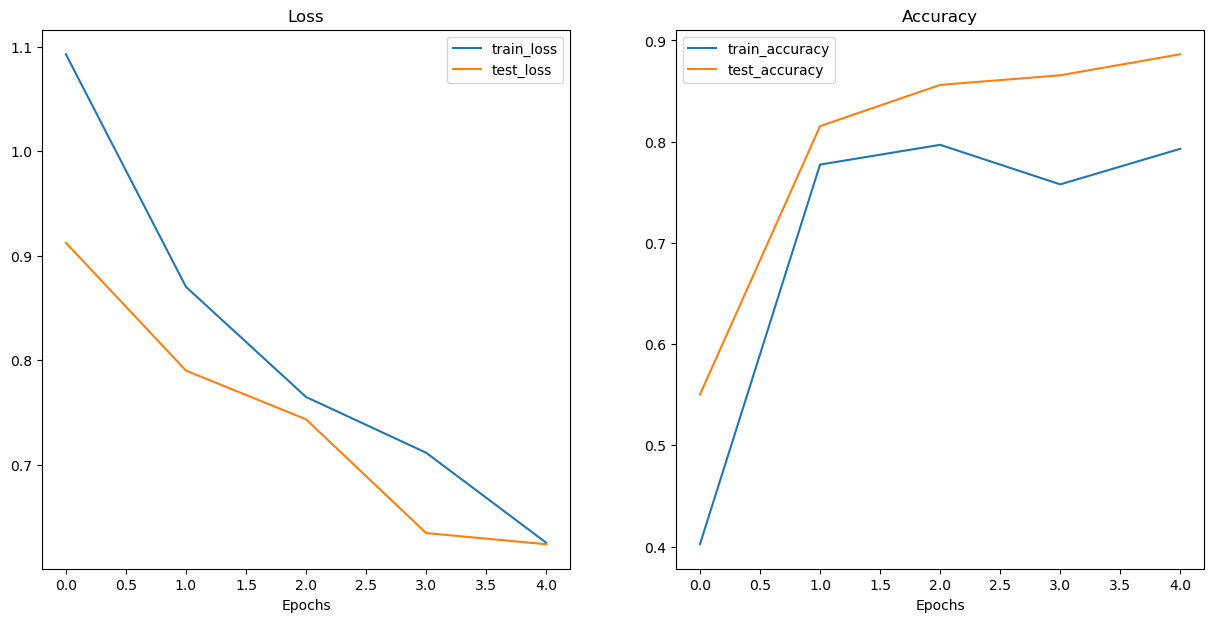

In [24]:
import requests
try:
    from helper_functions import plot_loss_curves

except:
    print(f"[INFO] Couldn't find helper functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6.Make predictions on images from the test set.

Let's adhere to the data explorer's motto of *visualize, visualize and visualize*!

And make some qualitative predictions on our test set.

Some things to keep in mind when making predictions/inference on testdata/custom data.

We have to make sure that our test/custom data is:
* Same shape - images need to be same shape as model was trained on.
* Same datatype - custom data should be in the same datatype
* Same device - custom data/ test data should be on the same device as the model.
* Same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same.

To do all of this, automagically, let's create a function called `pred_and_plot_image()`:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference (this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure it's dimensionality is suited for the model ( this mainly relates to the batch size)
7. Make a prediction on the image by passing to the model.
8. Convert the model's output logits to prediction probabilitiese using `torch.softmax()`
9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probablity from step 8.

In [42]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms
# 1.
def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names:List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):

    # 2.
    img = Image.open(image_path)

    # 3.
    if transform is not None:
        image_transform = transform

    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])


    ### Predict on image
    # 4. Make sure the model is on target device
    model.to(device)

    # 5. Turn on inference model
    model.eval()
    with torch.inference_mode():
        # 6. Transform the image and edd an extra batch dimension
        transformed_image = image_transform(img).unsqueeze(dim=0) # [batch_size, color_channels, height, width]
        # 7. Make a prediction on the transformed image by passing it to the model and also ensure target device
        target_image_pred = model(transformed_image.to(device))

    # 8.
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9.
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10.
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis("off")

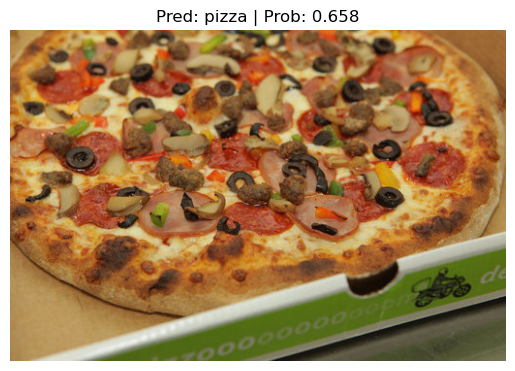

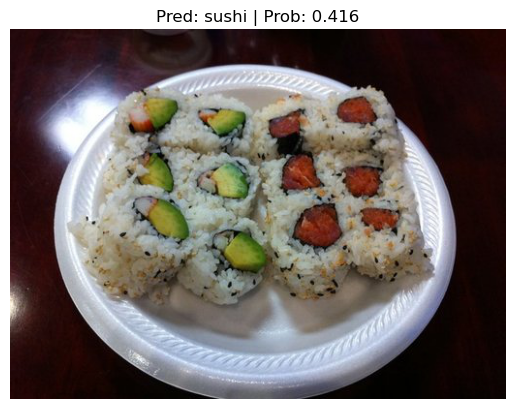

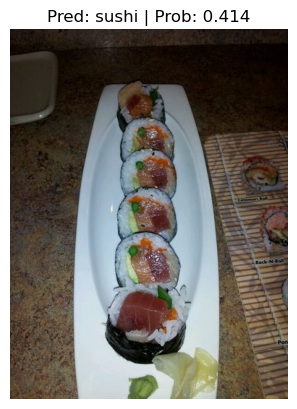

In [43]:
# Get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

### 6.1. Making predictions on a custom image

Let's make a prediction on the pizza dad image - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/04-pizza-dad.jpeg

In [44]:
# Download the image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if doesn't exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/04-pizza-dad.jpeg")
        print(f"Download {custom_image_path}...")
        f.write(request.content)

else:
    print(f"{custom_image_path} already exists, skipping download....")

data\04-pizza-dad.jpeg already exists, skipping download....


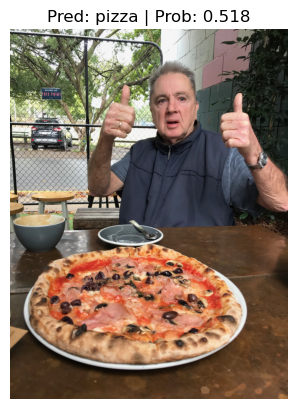

In [45]:
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)